<!---
Latex Macros
-->
$$
\newcommand{\Xs}{\mathcal{X}}
\newcommand{\Ys}{\mathcal{Y}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\repr}{\mathbf{f}}
\newcommand{\repry}{\mathbf{g}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\DeclareMathOperator{\argmin}{argmin}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
\newcommand{\indi}{\mathbb{I}}
$$

In [92]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append("..")
import statnlpbook.util as util
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

# Structured Prediction

In general there seems to be no emerging unified _theory of NLP_ to emerge, and most textbooks and courses explain NLP as 

> a collection of problems, techniques, ideas, frameworks, etc. that really are not tied together in any reasonable way other than the fact that they have to do with NLP.
>
>  -- <cite>[Hal Daume](http://nlpers.blogspot.co.uk/2012/12/teaching-intro-grad-nlp.html)</cite>

That's not to say though that they aren't cross-cutting patterns, general best practices and recipes that reoccur frequently. One such reoccurring pattern I found in many NLP papers and systems is what I like to refer to as the *[structured prediction](http://en.wikipedia.org/wiki/Structured_prediction) recipe*.

The general goal we address with this recipe is the following. We like to, given some input structure $\x \in \Xs$, predict a suitable output structure $\y \in \Ys$. In the context of NLP $\Xs$ may be the set of documents, and $\Ys$ a set of document classes (e.g. sports and business). $\Xs$ may also be the set of French sentences, and $\Ys$ the set of English sentences. In this case each $\y \in \Ys$ is a _structured_ object (hence the use of bold face). This structured **output** aspect of the problem has profound consequences on the methods used to address it (as opposed to structure in the input, which one can deal with relatively straight-forwardly). Generally we are also given some _training set_ $\train$ which may contain input-output pairs $(\x,\y)_i$, but possibly also just input data (in unsupervised learning), annotated data but for a different task (multi-task, distant, weak supervision, etc.), or some mixture of it. 


With the above ingredients the recipe goes as follows: 

 1. Define a parametrized _model_ or _scoring function_ \\(s_\params(\x,\y)\\) that measures the _match_ of a given \\(\x\\) and \\(\y\\). This model incorporates the background knowledge we have about the task, and usually involves _representations_  $\repr_\params(\x)$ and $\repry_\params(\y)$ that capture the character of the input and output relevant to the task---in the past representations were mostly handcrafted but with the advent of deep learning they tend to be learned from data now. The model is also controlled by a set of real-valued parameters \\(\params\\).
 1. _Learn_ the parameters \\(\params\\) from the training data \\(\train\\), ideally such that performance on the task of choice is optimized. This learning step usually involves some _continuous optimization problem_ that serves as a surrogate for the task performance we like to maximize. This problem defines a _loss function_ we have to minimise to optimise task performance.  
 1. Given an input \\(\x\\) _predict_ the highest-scoring (and hence best-matching) output structure $$ \y^* = \argmax_{\y\in\Ys} s(\x,\y) $$ to serve as the prediction of the model. Given that most of the structures we care about in NLP are discrete, this task usually involves some _discrete optimization problem_ and is important not just at _test time_ when the model is applied, but often also during training (as, intuitively, we like to train the model such that it _predicts well_). 
 
You will see examples of this recipe throughout the book, as well as frameworks and methods that make this recipe possible. It's worthwhile noting that good NLPers usually combine three skills in accordance with this recipe: 1. modelling, 2. continuous optimization and 3. discrete optimization. For the second and third some basic mathematical background is generally useful, for the first some understanding of the language phenomena you seek to model can be helpful. It's probably fair to say that modelling is the most important bit, and in practice this often shows through the fact that clever features (part of the model) beat clever optimization quite often. 

## A Simple Example

It is difficult to show this recipe in action without going into too much depth. We will do so by introducing a very simple structured prediction example that illustrates all aspects of the recipe. We consider the task of machine translation from English to German, and make the following (extremely unrealistic) assumptions:
* There are only 4 target German sentences we care about. All English sentences we encounter can be translated to one of these 4 sentences. 
* The lengths of the source English and target German sentence are sufficient representations of the problem. That is, one can decide which German sentence is the correct translation be comparing its lengths to the length of the English sentence. 

It is important to remember that while this is a toy example, the main steps and ingredients are found in every statistical NLP application. 

### Input and Output Spaces
First we define our input and output spaces $\Xs$ and $\Ys$. 

In [50]:
x_space = ['I ate an apple', 
           'I ate a red apple', 
           'Yesterday I ate a red apple', 
           'Yesterday I ate a red apply with a friend']
y_space = ['Ich aß einen Apfel',
           'Ich aß einen roten Apfel',
           'Gestern aß ich einen roten Apfel',
           'Gestern aß ich einen roten Apfel mit einem Freund']
data = list(zip(x_space,y_space))
train = data[:2]
test = data[2:]
util.Table(train)

I ate an apple,Ich aß einen Apfel
I ate a red apple,Ich aß einen roten Apfel


### Model
Modelling consists of two steps: finding suitable representations of $\x$ and $\y$, and measuring their compatibility using a scoring function. 
#### Representation
We incorporate the assumptions that only sentence lengths matter when translating by defining $\repr(\x)=|\x|$ and $\repry(\y)=|\y|$ where $|\cdot|$ counts the number of characters in the sentence.

In [6]:
def f(x):
    """Calculate a representation of the input `x`."""
    return len(x)
def g(y):
    """Calculate a representation of the output `y`."""
    return len(y)

#### Scoring Function
The scoring function only cares about the difference in length between the sentences when assessing the compatibility between the English and German sentence. We assume that German words are always a little longer than English words, and hence we cannot directly compare lengths but must scale the English length linearly:

$$
s_\param(\x,\y) = -| \param \repr(\x) - \repry(\y)|
$$

The single parameter $\param\in \mathbb{R}$ determines how the English length needs to be scaled to be close to its German counterpart.  

In [87]:
import math
def s(theta,x,y):
    """Measure the compatibility of sentences `x` and `y` using parameter `theta`"""
    return -abs(theta * f(x) - g(y))

util.Table([(x,y,f(x),g(y),s(1.0,x,y)) for x,y in data])

I ate an apple,Ich aß einen Apfel,14,18,-4.0
I ate a red apple,Ich aß einen roten Apfel,17,24,-7.0
Yesterday I ate a red apple,Gestern aß ich einen roten Apfel,27,32,-5.0
Yesterday I ate a red apply with a friend,Gestern aß ich einen roten Apfel mit einem Freund,41,49,-8.0


#### Loss Function
We want to _programmatically_ find out what the optimal $\param$ is. We do so by providing a simple loss function: for every training instance we receive a penalty of $1$ if the highest scoring translation is not the correct one. We can formalise this as follows:

$$
l(\param)=\sum_{(\x,\y) \in \train} \indi(\y\neq\y'_{\param})
$$
where $\y'_{\param} \in \Ys$ is the highest scoring German sentence 
$$\y'_{\param}=\argmax_\y s_\param(\x,\y).$$

In python this can be implemented as follows:

In [88]:
def loss(theta, data):
    """Measure the total number of errors made when predicting with parameter `theta` on training set `data`"""
    total = 0.0
    for x,y in data:
        max_score = -math.inf
        result = None
        for y_guess in y_space:
            score = s(theta,x,y_guess)
            if score > max_score:
                result = y_guess
                max_score = score
        if result != y:
            total += 1.0
    return total

loss(1.0, train)

1.0

### Learning
With the model and loss defined, we can now _learn_ the model parameters. Learning simply amounts to finding the parameter with minimal loss:

$$
\param^* = \argmin_{\param} l(\param) 
$$

Let us focus our attention on $\param \in [0,2]$ and investigate the loss landscape.

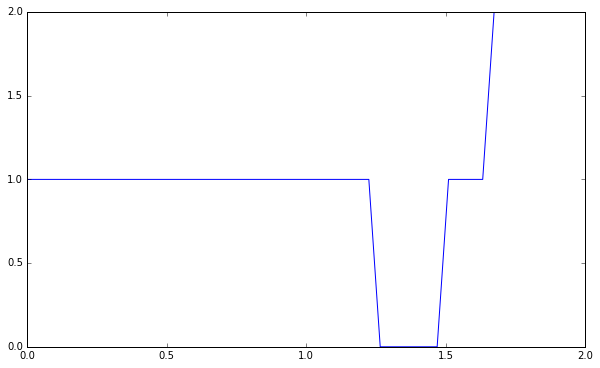

In [91]:
import numpy as np
thetas = np.linspace(0.0, 2.0, num=50)
plt.plot(thetas, [loss(theta,train) for theta in thetas])

We notice that there exist a set of optimal parameters for which the loss is zero and we achieve perfect prediction accuracy on the training set. We can find one such optimal parameter by sheer brute force: 

In [89]:
theta_star = thetas[np.argmin([loss(theta,train) for theta in thetas])]
theta_star

1.2653061224489794

### Prediction
Now that we have a trained model we can use it to predict translations on a test set. This amounts to finding 

$$\y'_{\param}=\argmax_\y s_\param(\x,\y).$$ 

Notice that we solved this problem already within the calculation of the loss. This is a common pattern in structured prediction: when minimising a training loss we often have to solve the prediction problem in the inner loop. In many cases this is the core bottleneck of computation. 

For completeness, we show how one can find the highest scoring German sentence $\y$ for a given English sentence $\x$ but note that this code can already be found the in loss code above. In practice one would try to reuse the prediction code below in the loss function above.

In [84]:
def predict(theta, x):
    """Find the most compatible output sentence given the input sentence `x` and parameter `theta`"""
    max_score = -math.inf
    result = None
    for y_guess in y_space:
        score = s(theta,x,y_guess)
        if score > max_score:
            result = y_guess
            max_score = score
    return result

# We can now predict the test set translation:
util.Table([(x,predict(theta_star, x)) for x,_ in test])

Yesterday I ate a red apple,Gestern aß ich einen roten Apfel
Yesterday I ate a red apply with a friend,Gestern aß ich einen roten Apfel mit einem Freund


### In Practice
In practice one needs to extend the above approach along several axes to be useful:

1. Usually the feature representations and scoring functions are more elaborate. They may involve several non-linear transformations of both input and output. 

1. The space of parameters is usually multi-dimensional (with possibly millions of dimensions). It is hence impossible to exhaustively search through this space as we have done above. Instead you will find numeric optimisation algorithms, often variants of Stochastic Gradient Descent. 

1. The size of the output space is often exponentional with respect to the input problem size. For example, in machine translation we have to search through *all* German sentences, not just 4. This means that we cannot exhaustively search this space either. Dynamic Programming, Greedy algorithms and integer linear programming are common approaches to solve this issue.  

### Background Reading

* Noah Smith, [Linguistic Structure Prediction](http://www.cs.cmu.edu/~nasmith/LSP/). Notice that his book can be downloaded for free when logging in through UCL. 